# Nengo example: Parsing simple commands

This example is a simplified version
of the language parsing model presented in
[Stewart & Eliasmith, 2013](http://compneuro.uwaterloo.ca/publications/stewart2013.html).
Please refer to that paper for the high-level details.

In [1]:
# Setup for the notebook
import matplotlib.pyplot as plt
%matplotlib inline

import nengo
import nengo_spa as spa

## Step 1: Create the model

In [11]:
sequence = 'WRITE ONE NONE WRITE TWO NONE THREE WRITE NONE'.split()

def input_vision(t):
    index = int(t / 0.5) % len(sequence)
    return sequence[index]

# Number of dimensions for the SPs
dimensions = 64

# Make a model object with the SPA network
model = spa.Network(label='Parser')
n_per_dim = 100

with model:
    # Specify the modules to be used
    model.vision = spa.Transcode(input_vision, output_vocab=dimensions)
    model.phrase = spa.State(dimensions, neurons_per_dimension=n_per_dim)
    model.motor = spa.State(dimensions, neurons_per_dimension=n_per_dim)
    model.noun = spa.State(dimensions, feedback=1., neurons_per_dimension=n_per_dim)
    model.verb = spa.State(dimensions, feedback=1., neurons_per_dimension=n_per_dim)
    
    # Specify the action mapping
    none_vision_cond = spa.dot(spa.sym.NONE-spa.sym.WRITE-spa.sym.ONE-spa.sym.TWO-spa.sym.THREE, model.vision)
    num_vision_cond = spa.dot(model.vision, spa.sym.ONE+spa.sym.TWO+spa.sym.THREE)
    
    
    with spa.ActionSelection() as action_sel:
        spa.ifmax("Write vis", spa.dot(model.vision, spa.sym.WRITE),
            model.vision >> model.verb)
        spa.ifmax("Memorise", num_vision_cond,
            model.vision >> model.noun)
        spa.ifmax("Write mem", 0.5*(none_vision_cond + spa.dot(model.phrase, spa.sym.WRITE*spa.sym.VERB)),
            model.phrase*~spa.sym.NOUN >> model.motor)
    
    model.noun*spa.sym.NOUN + model.verb*spa.sym.VERB >> model.phrase

## Step 2: Probe the output

In [3]:
with model:
    vision = nengo.Probe(model.vision.output, synapse=0.03)
    phrase = nengo.Probe(model.phrase.output, synapse=0.03)
    motor = nengo.Probe(model.motor.output, synapse=0.03)
    noun = nengo.Probe(model.noun.output, synapse=0.03)
    verb = nengo.Probe(model.verb.output, synapse=0.03)
    selected_actions = nengo.Probe(action_sel.thalamus.output, synapse=0.01)
    utility = nengo.Probe(action_sel.bg.input, synapse=0.01)

## Step 3: Run the model

In [4]:
with nengo.Simulator(model) as sim:
    sim.run(4.5)

Building finished in 0:00:13.                                                   
Simulating finished in 0:01:08.                                                 


## Step 4: Plot the results

Text(0,0.5,'Selected Action')

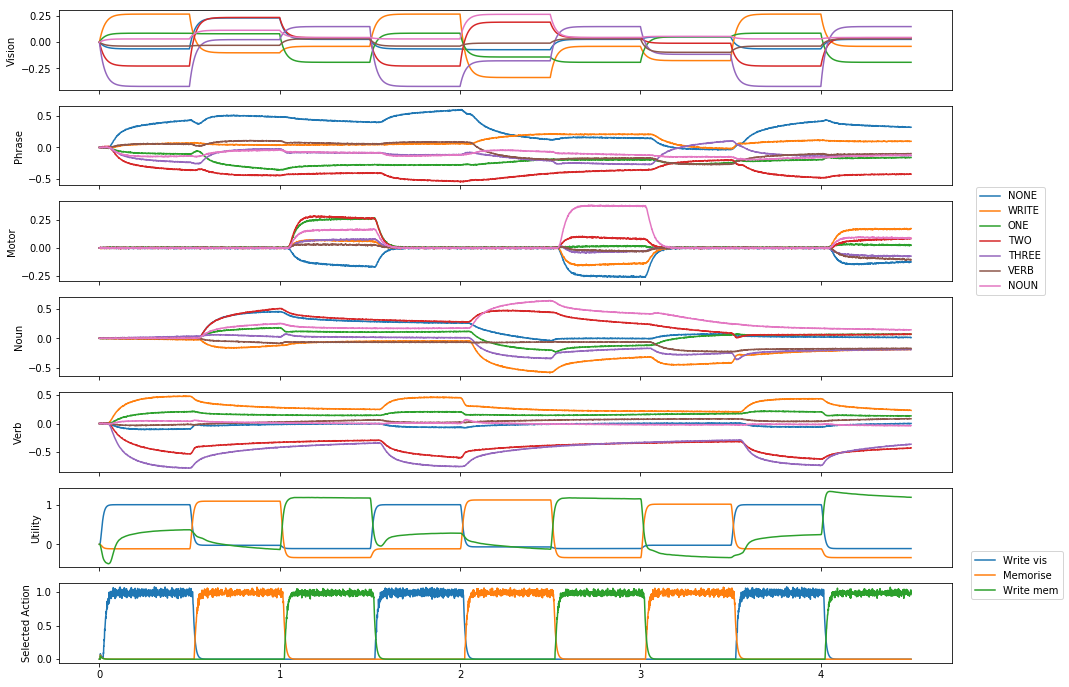

In [16]:
vocab = model.vocabs[dimensions]

fig, ax = plt.subplots(7, 1, sharex=True, figsize=(16,12))

ax[0].plot(sim.trange(), spa.similarity(sim.data[vision], vocab))
ax[0].set_ylabel('Vision')

ax[1].plot(sim.trange(), spa.similarity(sim.data[phrase], vocab))
ax[1].set_ylabel('Phrase')

ax[2].plot(sim.trange(), spa.similarity(sim.data[motor], vocab))
ax[2].legend(vocab.keys(), loc='right', bbox_to_anchor=(1.11, 0.5))
ax[2].set_ylabel('Motor')

ax[3].plot(sim.trange(), spa.similarity(sim.data[noun], vocab))
ax[3].set_ylabel('Noun')

ax[4].plot(sim.trange(), spa.similarity(sim.data[verb], vocab))
ax[4].set_ylabel('Verb')

ax[5].plot(sim.trange(), sim.data[utility])
ax[5].legend(tuple(action_sel.keys()), loc='right', bbox_to_anchor=(1.13, -0.1))
ax[5].set_ylabel('Utility')

ax[6].plot(sim.trange(), sim.data[selected_actions])
ax[6].set_ylabel('Selected Action')